<a href="https://colab.research.google.com/github/viththiananth/20221015-Convolutional-Neural-Network-on-Flower-Dataset/blob/main/Convolutional_Neural_Network_on_Flower_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. Import all necessary libraries for model building and training.

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten,Activation,Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/MyDrive/Data Set/flowers")

In [4]:
!ls

 daisy	    'my_model (1).h5'  'my_model (3).h5'   rose        tulip
 dandelion  'my_model (2).h5'   my_model.h5	   sunflower


## 3. Initialize the empty dictionaries to later use them as target and independent features. Load Data into variables. For this, data is images. Load different flower images in separate variables.

In [5]:
X=[]
Z=[]
FLOWER_DAISY_DIR='daisy'
FLOWER_DANDI_DIR='dandelion'
FLOWER_ROSE_DIR='rose'
FLOWER_SUNFLOWER_DIR='sunflower'
FLOWER_TULIP_DIR='tulip'

## 4. Create the dataset for each flower type.

In [6]:
def assign_label(img,flower_type):
    return flower_type

In [7]:
IMG_SIZE=150

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [8]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:10<00:00, 73.76it/s] 

764


In [9]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:14<00:00, 50.00it/s] 

1497


In [10]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 999/999 [00:15<00:00, 63.43it/s] 

2496


In [11]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:17<00:00, 58.72it/s] 

3548


In [12]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 794/794 [00:15<00:00, 51.78it/s] 

4342


## 5. Print random images with the names of flowers as labels.

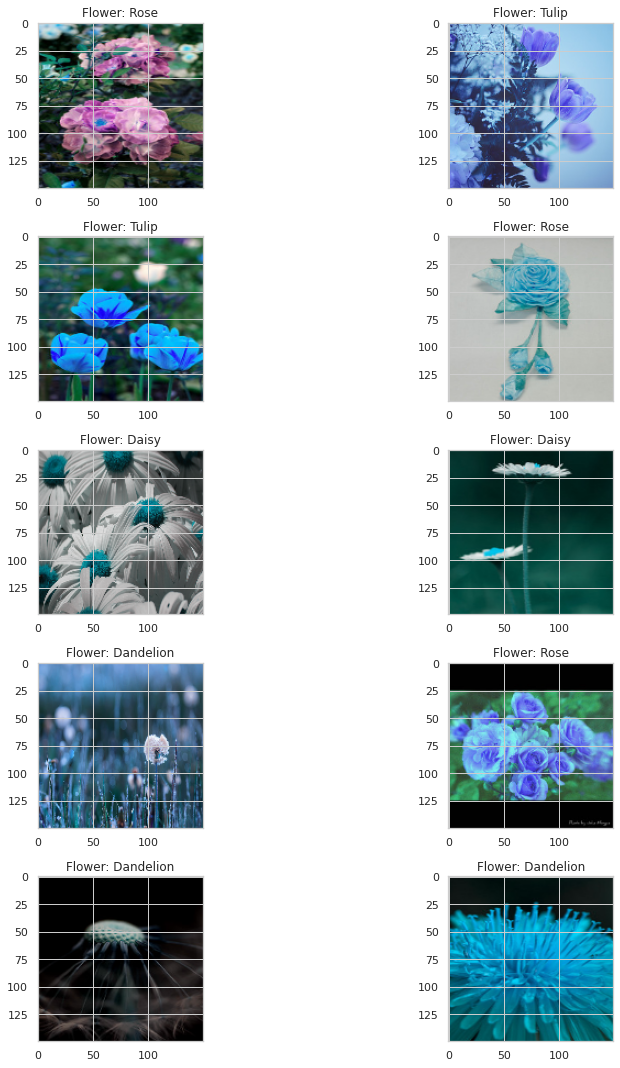

In [13]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

## 6. Encode categorical data, here flower names and perform standardization on input data (image pixels here).

In [14]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 7. Perform test-train split and print the X_train and y_train.

In [15]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## 8. Set a random seed to make your model capable of reproducing results multiple times.

In [16]:
np.random.seed(42)
rn.seed(42)
#tf.set_random_seed(42)
tf.random.set_seed(42)

## 9. Design the CNN architecture. Use a Sequential model.

In [17]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(512))

model.add(Activation('relu'))

model.add(Dense(5, activation = "softmax"))

## 10. Create a learning set and number of epochs and set the callback value to reduce the training rate. 

In [18]:
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 11. Perform data augmentation to avoid overfitting.

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 12. Compile the model and print the model summary.

In [20]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

## 13. Fit this model on your data and store the details into a variable. This variable will be used for plotting graphs later.

In [ ]:
batch_size=128
epochs=10

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
25/25 [==============================] - 190s 8s/step - loss: 1.6013 - accuracy: 0.2430 - val_loss: 1.6138 - val_accuracy: 0.2173
Epoch 2/10
25/25 [==============================] - 177s 7s/step - loss: 1.5952 - accuracy: 0.2510 - val_loss: 1.6127 - val_accuracy: 0.2173
Epoch 3/10
25/25 [==============================] - 175s 7s/step - loss: 1.5966 - accuracy: 0.2506 - val_loss: 1.6111 - val_accuracy: 0.2173
Epoch 4/10
25/25 [==============================] - 177s 7s/step - loss: 1.5965 - accuracy: 0.2519 - val_loss: 1.6074 - val_accuracy: 0.2173
Epoch 5/10
25/25 [==============================] - 177s 7s/step - loss: 1.5972 - accuracy: 0.2532 - val_loss: 1.6122 - val_accuracy: 0.2173
Epoch 6/10
25/25 [==============================] - 180s 7s/step - loss: 1.5954 - accuracy: 0.2478 - val_loss: 1.6116 - val_accuracy: 0.2173
Epoch 7/10
25/25 [==============================] - 175s 7s/step - loss: 1.5941 - accuracy: 0.2513 - val_loss: 1.6126 - val_accuracy: 0.2173
Epoch 8/10
25

## 14. Plot the loss and accuracy graph for both train and test dataset.

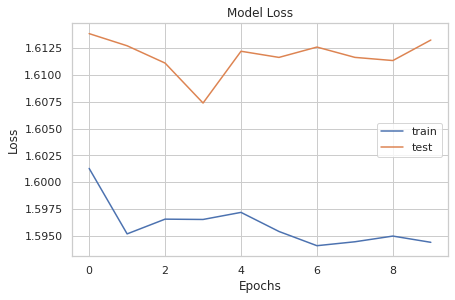

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

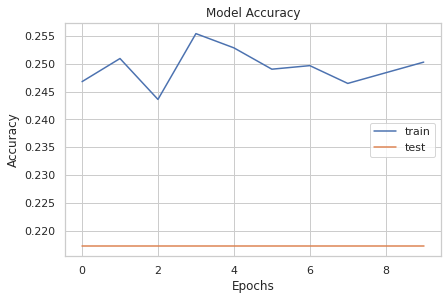

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## 15. Optimize the model performance in order to increase the accuracy. You can make some changes in the model architecture. 

In [22]:
model_1 = Sequential()
model_1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model_1.add(MaxPooling2D(pool_size=(2,2)))


model_1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model_1.add(MaxPooling2D(pool_size=(2,2)))
 

model_1.add(Conv2D(filters =64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model_1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dense(5, activation = "softmax"))

In [23]:
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [24]:
model_1.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 64)      

## 16. Fit the model to the dataset, take care of the number of epochs till what you want to train your model.

In [28]:
batch_size=128
epochs=10

History = model_1.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (x_test,y_test),
                              verbose = 1, 
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
25/25 [==============================] - 212s 8s/step - loss: 1.5093 - accuracy: 0.3251 - val_loss: 1.4151 - val_accuracy: 0.3821
Epoch 2/10
25/25 [==============================] - 212s 8s/step - loss: 1.3139 - accuracy: 0.4284 - val_loss: 1.2867 - val_accuracy: 0.4411
Epoch 3/10
25/25 [==============================] - 213s 9s/step - loss: 1.2053 - accuracy: 0.4942 - val_loss: 1.1042 - val_accuracy: 0.5516
Epoch 4/10
25/25 [==============================] - 210s 8s/step - loss: 1.0742 - accuracy: 0.5761 - val_loss: 1.0551 - val_accuracy: 0.6013
Epoch 5/10
25/25 [==============================] - 213s 9s/step - loss: 1.0232 - accuracy: 0.6061 - val_loss: 0.9601 - val_accuracy: 0.6151
Epoch 6/10
25/25 [==============================] - 211s 9s/step - loss: 0.9894 - accuracy: 0.6106 - val_loss: 1.0282 - val_accuracy: 0.6031
Epoch 7/10
25/25 [==============================] - 209s 8s/step - loss: 0.9315 - accuracy: 0.6359 - val_loss: 0.9467 - val_accuracy: 0.6160
Epoch 8/10
25

## 17. Print the graphs for loss and accuracy for the new model

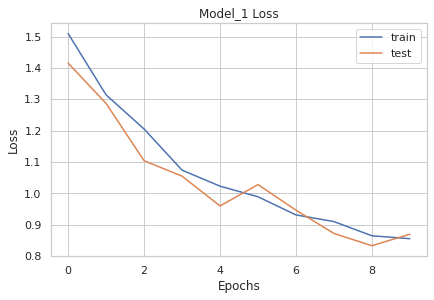

In [29]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model_1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

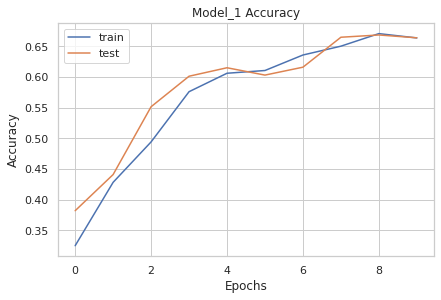

In [30]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model_1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## Visualizing Predictons on the Validation Set

In [31]:
pred=model_1.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

34/34 [==============================] - 37s 1s/step


In [32]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

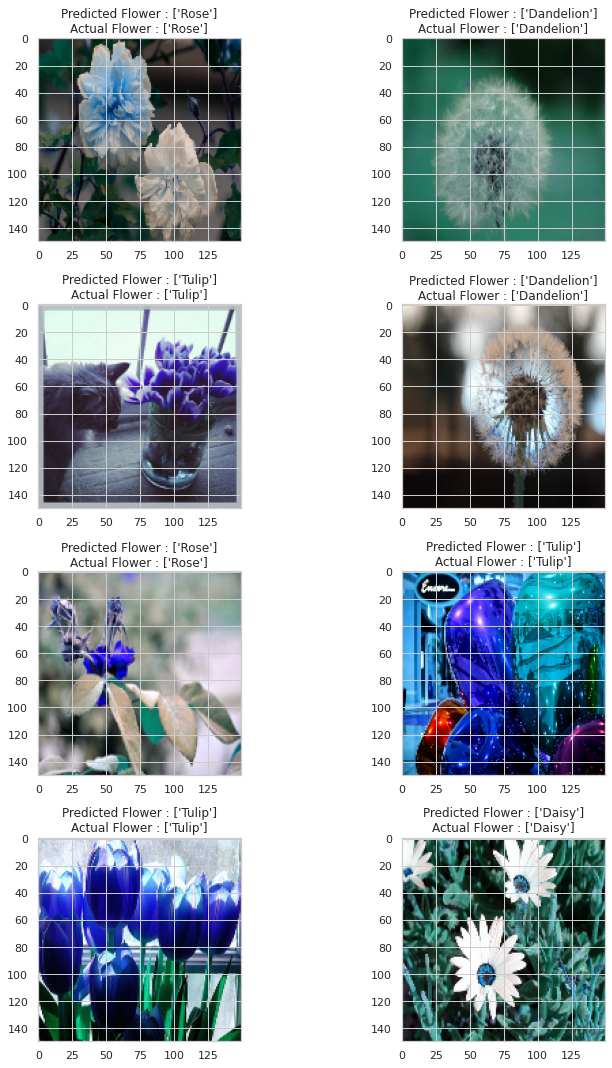

In [33]:
# CORRECTLY CLASSIFIED FLOWER IMAGES
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : " + str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
        plt.tight_layout()
        count+=1

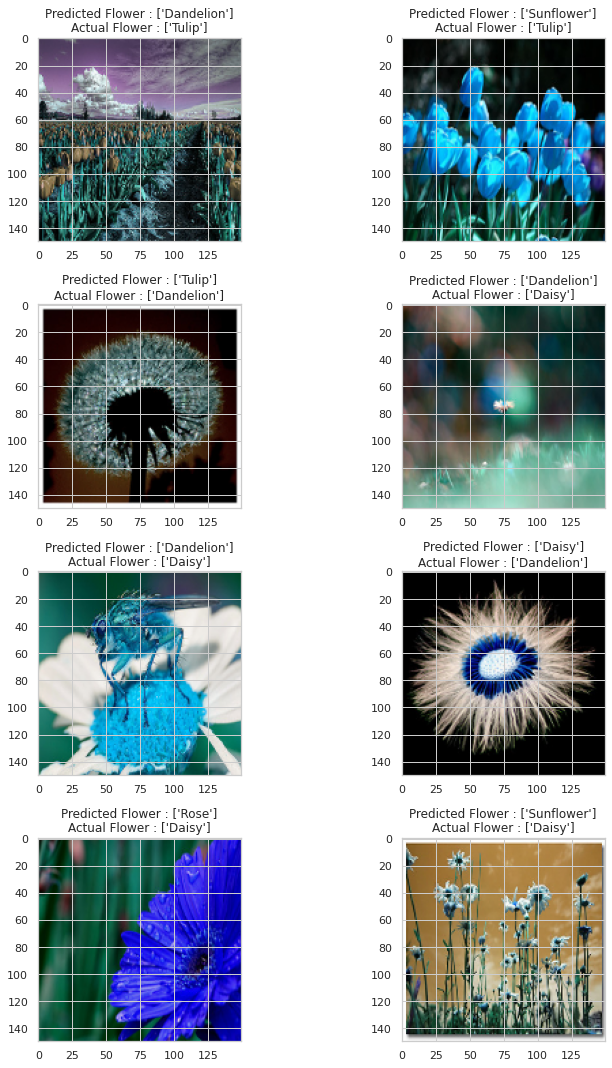

In [34]:
# MISCLASSIFIED IMAGES
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : " + str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1

## 19. Export the model.

In [35]:
import os
import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.9.2


In [36]:
model_1.save('my_model_updated.h5')

In [37]:
!ls

 daisy		   'my_model (2).h5'   my_model_updated.h5   tulip
 dandelion	   'my_model (3).h5'   rose
'my_model (1).h5'   my_model.h5        sunflower
